<a href="https://colab.research.google.com/github/PedroDS4/Sistema_de_comunicacoes_ideal/blob/main/Project_Idealized_comunication_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Sistema de Transmissão de dados idealizado**
O sistema de transmissão de dados implementado nesse código fará a simulação realista de um sistema, considerando os efeitos de canal e todas as etapas do transmissor e receptor



##**Funções importantes**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import remez, freqz, convolve


def letrapam(string):
  """
  Codifica uma string usando 4-PAM

  Args:
    string: A string a ser codificada.

  Returns:
    Um array NumPy contendo os símbolos 4-PAM codificados.
  """

  # Converte a string em uma sequência de bits
  bits = ''.join(format(ord(c), '08b') for c in string)

  # Mapeia os bits para símbolos 4-PAM
  symbols = []
  for i in range(0, len(bits), 2):
    dibits = bits[i:i+2]
    if dibits == '00':
      symbols.append(-3)
    elif dibits == '01':
      symbols.append(-1)
    elif dibits == '10':
      symbols.append(1)
    elif dibits == '11':
      symbols.append(3)

  return np.array(symbols)

def pamdecod(symbols):
  """
  Decodifica símbolos 4-PAM em uma string.

  Args:
    symbols: Um array NumPy contendo os símbolos 4-PAM.

  Returns:
    A string decodificada.
  """

  # Mapeia os símbolos 4-PAM de volta para bits
  bits = ''
  for symbol in symbols:
    if symbol == -3:
      bits += '00'
    elif symbol == -1:
      bits += '01'
    elif symbol == 1:
      bits += '10'
    elif symbol == 3:
      bits += '11'

  # Converte a sequência de bits de volta para uma string
  string = ''.join(chr(int(bits[i:i+8], 2)) for i in range(0, len(bits), 8))

  return string



########################Funções importantes do receptor#########################
def quantizador(x,niveis):
  """
    Quantiza um sinal com base em níveis fornecidos.

    Args:
        x: Sinal de entrada.
        niveis: Array de níveis de quantização.

    Returns:
        Sinal quantizado.
  """

  L = len(niveis)
  N = len(x)
  x_q = np.zeros(N,dtype = int)
  for i in range(N):
    xq_i = x[i]
    e = niveis - xq_i
    j = np.argmin(np.abs(e))
    x_q[i] = niveis[j]

  return x_q



In [7]:
# Exemplo de uso
symbols = np.array([-3, -1, 1, 3, -3, -1, 1, 3])
string = pamdecod(symbols)
print(string)
# Exemplo de uso
string = "Olá mundo"
symbols = letrapam(string)
string_rec = pamdecod(symbols)
print(string_rec)
print(symbols)


Olá mundo
[-1 -3  3  3 -1  1  3 -3  3  1 -3 -1 -3  1 -3 -3 -1  1  3 -1 -1  3 -1 -1
 -1  1  3  1 -1  1 -1 -3 -1  1  3  3]


##**Transmissor**
As etapas do transmissor são
* Codificação
* Filtro de pulso
* Modulação
* Transmissão ao Canal

Essas etapas serão implementadas abaixo, e sua matemática será descrita abaixo.


### **Matemática da Transmissão**
**Codificação**
A codificação é o ato de transformar os caracteres em string que irão ser transmitidos em bits, por exemplo

$$
"A"  -> 0100 0001
$$

$$
"B"  -> 0100 0010
$$

essa conversão pode ser encontrada diretamente na tabela ASCII, e existem funções que ja fazem essa conversão.


Então seja uma sequência a ser transmitida, como por exemplo abaixo

$$
Str = "Olá \ mundo"
$$

Quando codificada, gera-se um vetor com os bits dos símbolos, que depois irá ser convertido em números únicos

$$
s = letrapam(str)
$$

O tipo de codificação será uma 4-PAM
dada pela relação

00 -> -3

01 -> -1

10 ->  1

11 -> 3



**Filtro de pulso**
Depois da codificação, os símbolos dos caracteres precisam ser armazenados em um vetor, para serem transformados em um sinal analógico.

Esse vetor em que os simbolos são adicionados, pode ser representado por um trem de impulsos, dado por

$$
s[n] = \sum_{k = 0}^{M} s_k \cdot δ[n - kM]
$$


e esse sinal de simbolos é convoluído com uma forma de pulso, $p[n]$, e o sinal resultante que será transmitido, fica

$$
x[n] = s[n] \ast p[n] = \sum_{k = 0}^{M} s_k \cdot δ[n - kM] \ast p[n]
$$

então

$$
x[n] =  \sum_{k = 0}^{M} s_k \cdot (p[n] \ast \delta[n-kM]) = \sum_{k = 0}^{M} s_k p[n - kM]
$$

e o sinal $x[n]$ é passado por um conversor D/A para a modulação e posteriormente transmissão.

**Modulação**
A modulação é o ato de deslocarmos o sinal em frequẽncia, para poder transmití-la em um certo canal
Matematicamente é dada por

$$
x_{m}(t) = x(t) \cdot cos(2\pi f_c t)
$$



In [8]:
#Exemplo de uma transmissão de um sinal

#Codificação
mensagem = "Olá mundo"
s = letrapam(mensagem)
N = len(s)
M = 10
mup = np.zeros(N*M)
for i in range(N):
  mup[i*M] = s[i]



#Filtro de pulso
Ts = 1/20000
Fs = 1/Ts


p_hamming = np.hamming(M)


x = np.convolve(mup,p_hamming,'same')
t = np.arange(0,len(x)*Ts,Ts)


#Modulação
fc = 5000
x_m = x * np.cos(2*np.pi*fc*t)

##**Receptor**
Depois de passar pelo canal, o sinal chega ao receptor, onde as manipulações que foram feitas para transmití-lo precisam ser revertidas ou alteradas, para recuperar a mensagem original transmitida, além disso precisamos de algum jeito compensar os efeitos de canal.


###**Demodulação**
A demodulação é o ato de reverter a modulação feita no transmissor, ou seja, multiplicar por outro cosseno para que surja uma componente de frequências centrada para poder ser feita a filtragem do sinal e recuperá-lo.

Seja o sinal modulado dado por
$$
x_m(t) = x(t) \cdot cos(2 \pi f_c t)
$$

para demodularmos esse sinal, multiplicamos esse sinal recebido mais uma vez por um cosseno na mesma frequência e fase, assim

$$
x_r(t) = x_m(t) \cdot cos(2 \pi f_c t) = x(t) cos^2(2 \pi f_c t)
$$

usando a seguinte identidade trigonométrica

$$
cos^2(2 \pi f_c t) = \frac{ 1 + cos(4 \pi f_c t)}{2}
$$

vemos que surge uma componente de frequência ainda mais alta, e uma réplica do espectro do sinal original na origem, então para obtermos de volta o sinal $x(t)$ basta filtrar o sinal resultante, então

$$
x(t) = 2 \cdot LPF\{\ \frac{ x(t) }{2} + \frac{ x(t) cos(4 \pi f_c t)}{2}  \}\
$$


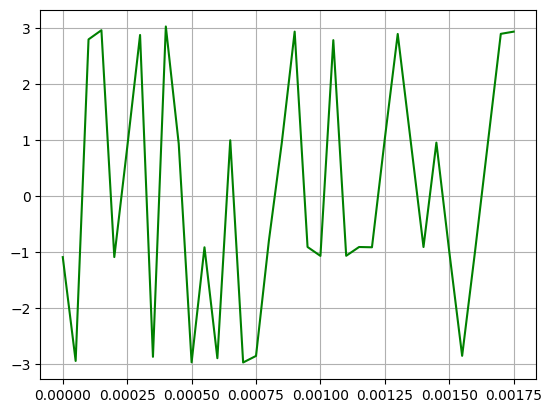

Mensagem original: Olá mundo
Mensagem codificada: [-1 -3  3  3 -1  1  3 -3  3  1 -3 -1 -3  1 -3 -3 -1  1  3 -1 -1  3 -1 -1
 -1  1  3  1 -1  1 -1 -3 -1  1  3  3]
Mensagem quantizada: [-1 -3  3  3 -1  1  3 -3  3  1 -3 -1 -3  1 -3 -3 -1  1  3 -1 -1  3 -1 -1
 -1  1  3  1 -1  1 -1 -3 -1  1  3  3]
Mensagem decodificada: Olá mundo
Número de erros: 0


In [9]:
#Demodulação

x_cos = x_m * np.cos(2 * np.pi * fc *t)

# Filtro demodulador
B = 5000
Fn = Fs/2
delta_f = 100
fs1 = B + delta_f
fp1 = fs1 - delta_f/2


# Parâmetros do filtro
f = [0, fp1, fs1, Fn]  # Faixas normalizadas
a = [1,0]  # Especificação do ganho (0 na primeira faixa, 1 na segunda)
fl = 200  # Ordem do filtro


# Projeto do filtro usando a função remez
h = remez(fl + 1, f, a, fs = Fs)  # remez exige a frequência de amostragem e ja faz a normalização

x_demod = 2*np.convolve(x_cos, h,'same')


# Decimação para obter mais uma vez os picos dos simbolos
z = x_demod[::M]
t_z = np.arange(len(z)) * Ts


# Visualizar o sinal após decimação
plt.figure()
plt.plot(t_z, z, 'green')
plt.grid(True)
plt.show()



# Quantização
niveis = np.array([-3, -1, 1, 3])
m_prime = quantizador(z, niveis)


print(f"Mensagem original: {mensagem}")
print(f"Mensagem codificada: {s}")
print(f"Mensagem quantizada: {m_prime}")

# Decodificação
string_rec = pamdecod(m_prime)
print(f"Mensagem decodificada: {string_rec}")


num_errors = np.sum(np.abs(m_prime-s))
print(f'Número de erros: {num_errors}')